# 배터리 폭발 위험 구간 예측 분석

# 총 배터리 개수(데이터 개수 파악)

In [11]:
import pandas as pd

# 데이터 불러오기
df = pd.read_csv('battery_failure_surfaces.csv')

# 배터리 ID 생성 로직
# 1. 현재 행의 cycle이 이전 행보다 작으면(음수면) 새로운 배터리가 시작된 것으로 간주 (True)
# 2. cumsum()을 통해 True가 나올 때마다 ID 숫자를 1씩 증가시킴
df['battery_id'] = (df['cycle'].diff() < 0).cumsum()

# 결과 확인
print(f"총 발견된 배터리 개수: {df['battery_id'].nunique()}개")

총 발견된 배터리 개수: 1200개


# 종류별 배터리의 개수

In [12]:
import pandas as pd

# 1. 데이터 불러오기 및 배터리 ID 생성
df = pd.read_csv('battery_failure_surfaces.csv')
df['battery_id'] = (df['cycle'].diff() < 0).cumsum()

# 2. 종류별 배터리 개수 확인
print("=== 배터리 종류별 개수 ===")
print(df.groupby('cell_chemistry')['battery_id'].nunique())

# 3. 종류별로 데이터 분리 (DataFrame 나누기)
# 각 변수에 해당 종류의 데이터만 저장됩니다.
df_nmc = df[df['cell_chemistry'] == 'Li-ion NMC'].copy()
df_lfp = df[df['cell_chemistry'] == 'LFP'].copy()
df_solid = df[df['cell_chemistry'] == 'Solid-State'].copy()

# 확인: 잘 나뉘었는지 shape 출력
print(f"\nLi-ion NMC 데이터 크기: {df_nmc.shape}")
print(f"LFP 데이터 크기: {df_lfp.shape}")
print(f"Solid-State 데이터 크기: {df_solid.shape}")

=== 배터리 종류별 개수 ===
cell_chemistry
LFP            400
Li-ion NMC     400
Solid-State    400
Name: battery_id, dtype: int64

Li-ion NMC 데이터 크기: (127884, 12)
LFP 데이터 크기: (159338, 12)
Solid-State 데이터 크기: (190031, 12)


# 데이터 결측치 제거

In [13]:
import pandas as pd

# -------------------------------------------------------
# [함수 정의] 이상치 제거 로직
# -------------------------------------------------------
def remove_outliers(data):
    # 1. 원본 데이터 개수 저장 (제거된 개수 확인용)
    original_count = len(data)
    
    # 2. 제거 기준 설정 (Masking)
    # (1) 용량 유지율: 0% 미만(음수)이거나 105%를 초과하는 값은 제거
    #     (100%를 약간 넘는 것은 초기 캘리브레이션 오차로 허용)
    mask_capacity = (data['capacity_retention_%'] >= 0) & (data['capacity_retention_%'] <= 105)
    
    # (2) 내부 저항: 0 이하인 값은 물리적으로 불가능하므로 제거
    mask_resistance = (data['internal_resistance_mOhm'] > 0)
    
    # 3. 조건 적용 (두 조건을 모두 만족하는 데이터만 남김)
    clean_data = data[mask_capacity & mask_resistance].copy()
    
    # 4. 결과 출력
    removed_count = original_count - len(clean_data)
    print(f"[{data['cell_chemistry'].iloc[0]}] 삭제된 이상치 개수: {removed_count}개")
    
    return clean_data

# -------------------------------------------------------
# [실행] 각 배터리 종류별로 함수 적용
# -------------------------------------------------------

# 기존에 나눴던 데이터프레임이 있다고 가정하고 실행합니다.
df_nmc_clean = remove_outliers(df_nmc)
df_lfp_clean = remove_outliers(df_lfp)
df_solid_clean = remove_outliers(df_solid)

# 최종 확인
print("\n=== 정제 완료된 데이터 크기 ===")
print(f"Li-ion NMC : {df_nmc_clean.shape}")
print(f"LFP        : {df_lfp_clean.shape}")
print(f"Solid-State: {df_solid_clean.shape}")

[Li-ion NMC] 삭제된 이상치 개수: 0개
[LFP] 삭제된 이상치 개수: 0개
[Solid-State] 삭제된 이상치 개수: 0개

=== 정제 완료된 데이터 크기 ===
Li-ion NMC : (127884, 12)
LFP        : (159338, 12)
Solid-State: (190031, 12)


In [19]:
import pandas as pd

# 데이터 로드 및 ID 생성
df = pd.read_csv('battery_failure_surfaces.csv')
df['battery_id'] = (df['cycle'].diff() < 0).cumsum()

# ---------------------------------------------------------
# [Step 1] 용량 80% 이상인 '안전 그룹' 찾기
# ---------------------------------------------------------

# 1. 각 배터리별로 '최저 용량'을 확인합니다.
# (한 번이라도 80% 밑으로 찍었으면 탈락시키기 위함)
min_capacity = df.groupby('battery_id')['capacity_retention_%'].min()

# 2. 80% 이상을 유지한 배터리 번호(ID)만 골라냅니다.
safe_ids = min_capacity[min_capacity >= 80].index

# 3. 전체 데이터에서 이 배터리들의 데이터만 뽑아냅니다.
safe_group_df = df[df['battery_id'].isin(safe_ids)]

print(f"찾아낸 안전 배터리 개수: {len(safe_ids)}개")

찾아낸 안전 배터리 개수: 604개


=== 종류별 생존/고장 현황 ===
status          Safe  Unsafe
cell_chemistry              
LFP              168     232
Li-ion NMC        87     313
Solid-State      349      51


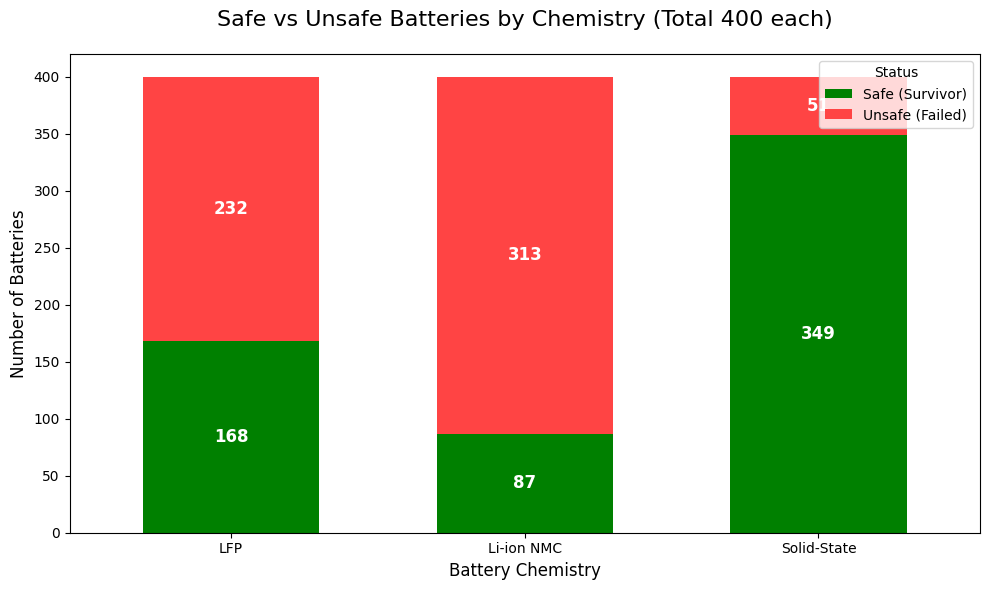

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. 데이터 로드 및 배터리 ID 생성
df = pd.read_csv('battery_failure_surfaces.csv')
df['battery_id'] = (df['cycle'].diff() < 0).cumsum()

# ---------------------------------------------------------
# [Step 1] 배터리 상태 판별 (Safe vs Unsafe)
# ---------------------------------------------------------
# 배터리별로 '최저 용량(min)'을 구해서 80% 이상인지 확인합니다.
battery_stats = df.groupby('battery_id').agg({
    'capacity_retention_%': 'min',  # 최저 용량 확인
    'cell_chemistry': 'first'       # 배터리 종류 확인
})

# 상태 분류 로직 적용
# 80% 이상이면 'Safe', 아니면 'Unsafe'로 라벨링
battery_stats['status'] = battery_stats['capacity_retention_%'].apply(
    lambda x: 'Safe' if x >= 80 else 'Unsafe'
)

# ---------------------------------------------------------
# [Step 2] 종류별 개수 집계 (Cross Tabulation)
# ---------------------------------------------------------
# 행: 배터리 종류, 열: 상태(Safe, Unsafe)로 개수를 셉니다.
summary_df = pd.crosstab(battery_stats['cell_chemistry'], battery_stats['status'])

# 시각화할 때 보기 좋게 순서 정렬 (Safe를 먼저, Unsafe를 나중에)
summary_df = summary_df[['Safe', 'Unsafe']]

# 결과 데이터 확인 (터미널 출력용)
print("=== 종류별 생존/고장 현황 ===")
print(summary_df)

# ---------------------------------------------------------
# [Step 3] 시각화 (Stacked Bar Chart)
# ---------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6))

# 누적 막대그래프 그리기
# color=['green', 'red']: Safe는 초록색, Unsafe는 빨간색
summary_df.plot(kind='bar', stacked=True, color=['green', '#FF4444'], ax=ax, width=0.6)

# 그래프 꾸미기
plt.title('Safe vs Unsafe Batteries by Chemistry (Total 400 each)', fontsize=16, pad=20)
plt.ylabel('Number of Batteries', fontsize=12)
plt.xlabel('Battery Chemistry', fontsize=12)
plt.xticks(rotation=0)  # X축 글자 가로로 정렬
plt.legend(title='Status', labels=['Safe (Survivor)', 'Unsafe (Failed)'], loc='upper right')

# 막대 안에 숫자 표시하기 (Bar Label)
for c in ax.containers:
    # 각 막대(컨테이너)의 중앙에 숫자를 흰색으로 표시
    ax.bar_label(c, label_type='center', color='white', fontsize=12, weight='bold')

plt.tight_layout()
plt.show()

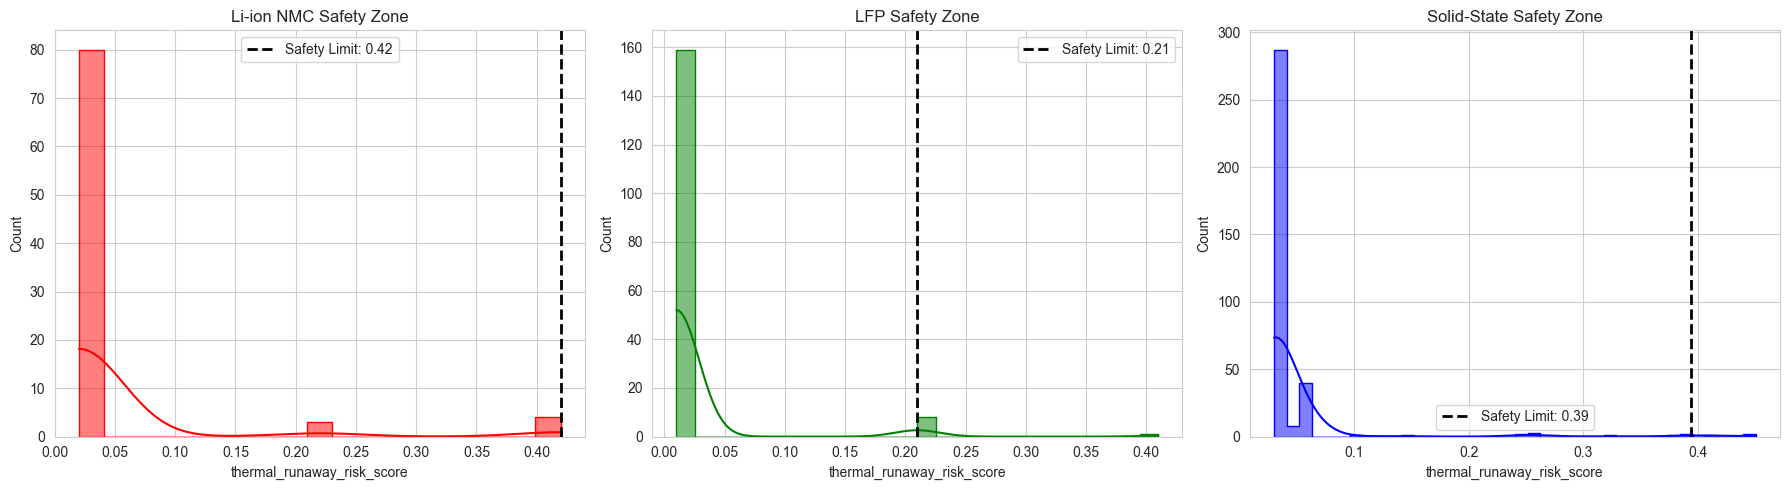

C:\Users\user\AppData\Local\Temp\ipykernel_19952\46856510.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=analysis_df, x='status', y='charge_rate_C', palette=['#99FF99','#FF9999'], ax=axes[0])
C:\Users\user\AppData\Local\Temp\ipykernel_19952\46856510.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=analysis_df, x='status', y='cell_temperature_C', palette=['#99FF99','#FF9999'], ax=axes[1])


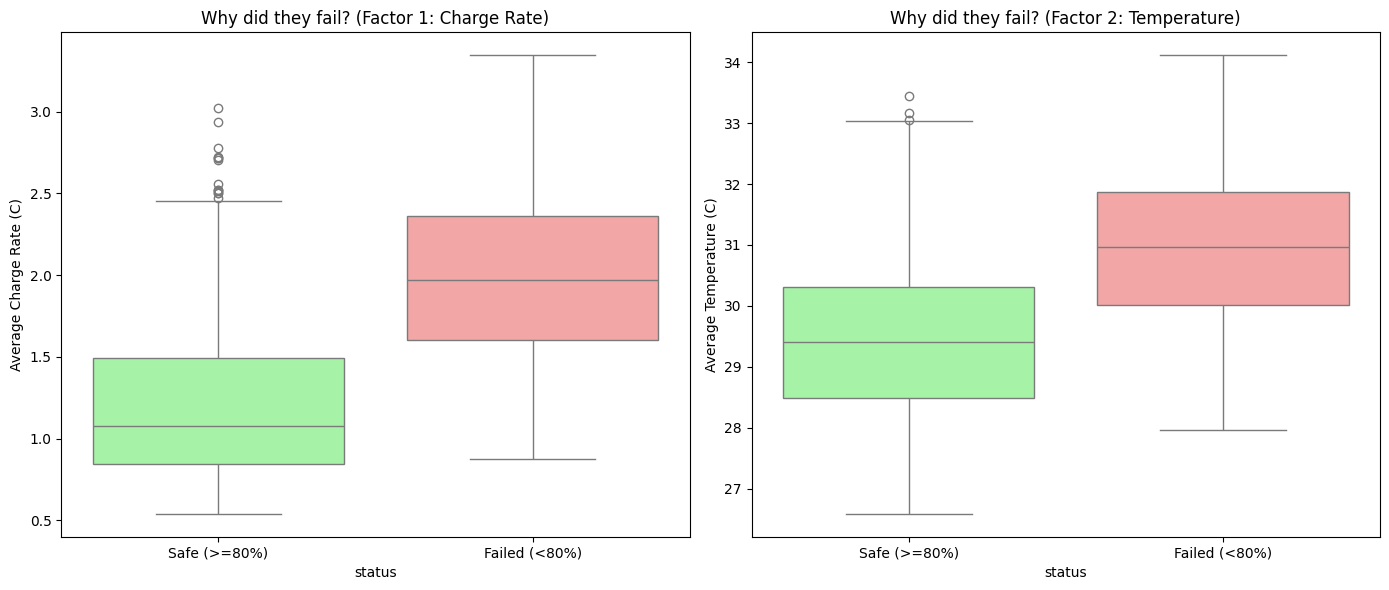

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 로드 및 전처리
df = pd.read_csv('battery_failure_surfaces.csv')
df['battery_id'] = (df['cycle'].diff() < 0).cumsum()

# 2. 고장군(Failed) vs 정상군(Safe) 분류
# 각 배터리의 최저 용량이 80 미만이면 'Failed', 아니면 'Safe'
battery_status = df.groupby('battery_id')['capacity_retention_%'].min().apply(
    lambda x: 'Failed (<80%)' if x < 80 else 'Safe (>=80%)'
).reset_index(name='status')

# 3. 배터리별 주요 특징(충전속도, 온도) 가져오기
features = df.groupby('battery_id').agg({
    'charge_rate_C': 'mean',
    'cell_temperature_C': 'mean',
    'cell_chemistry': 'first'
}).reset_index()

# 두 데이터 합치기
analysis_df = pd.merge(battery_status, features, on='battery_id')

# 4. 비교 시각화 (Boxplot)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# (1) 충전 속도 비교
sns.boxplot(data=analysis_df, x='status', y='charge_rate_C', palette=['#99FF99','#FF9999'], ax=axes[0])
axes[0].set_title('Why did they fail? (Factor 1: Charge Rate)')
axes[0].set_ylabel('Average Charge Rate (C)')

# (2) 온도 비교
sns.boxplot(data=analysis_df, x='status', y='cell_temperature_C', palette=['#99FF99','#FF9999'], ax=axes[1])
axes[1].set_title('Why did they fail? (Factor 2: Temperature)')
axes[1].set_ylabel('Average Temperature (C)')

plt.tight_layout()
plt.show()

In [42]:
import pandas as pd

# 1. 원본 데이터 불러오기
df = pd.read_csv('battery_failure_surfaces.csv')

# 2. 배터리 ID 생성
# 사이클이 갑자기 줄어드는 지점(새로운 배터리 시작)을 기준으로 ID 부여
df['battery_id'] = (df['cycle'].diff() < 0).cumsum()

# 3. 종류별로 데이터 분리
df_nmc = df[df['cell_chemistry'] == 'Li-ion NMC'].copy()
df_lfp = df[df['cell_chemistry'] == 'LFP'].copy()
df_solid = df[df['cell_chemistry'] == 'Solid-State'].copy()

# 4. 각각 별도의 CSV 파일로 저장
df_nmc.to_csv('Li-ion_NMC_data.csv', index=False)
df_lfp.to_csv('LFP_data.csv', index=False)
df_solid.to_csv('Solid-State_data.csv', index=False)

print("모든 파일이 성공적으로 분리되어 저장되었습니다.")

모든 파일이 성공적으로 분리되어 저장되었습니다.


전체 데이터 기준 'thermal_runaway_risk_score'와의 상관계수:
thermal_runaway_risk_score     1.000000
fast_charge_exposure_cycles    0.994423
irreversible_damage_index      0.704125
internal_resistance_mOhm       0.703597
charge_rate_C                  0.494087
cell_temperature_C             0.306920
discharge_rate_C              -0.019480
capacity_retention_%          -0.858332
cumulative_high_temp_cycles         NaN
Name: thermal_runaway_risk_score, dtype: float64
------------------------------

Li-ion NMC 기준 'thermal_runaway_risk_score'와의 상관계수 Top 5:
thermal_runaway_risk_score     1.000000
fast_charge_exposure_cycles    0.992310
irreversible_damage_index      0.732708
internal_resistance_mOhm       0.712682
charge_rate_C                  0.650962
cell_temperature_C             0.393045
Name: thermal_runaway_risk_score, dtype: float64

LFP 기준 'thermal_runaway_risk_score'와의 상관계수 Top 5:
thermal_runaway_risk_score     1.000000
fast_charge_exposure_cycles    0.996218
internal_resistance_mOhm       0.74

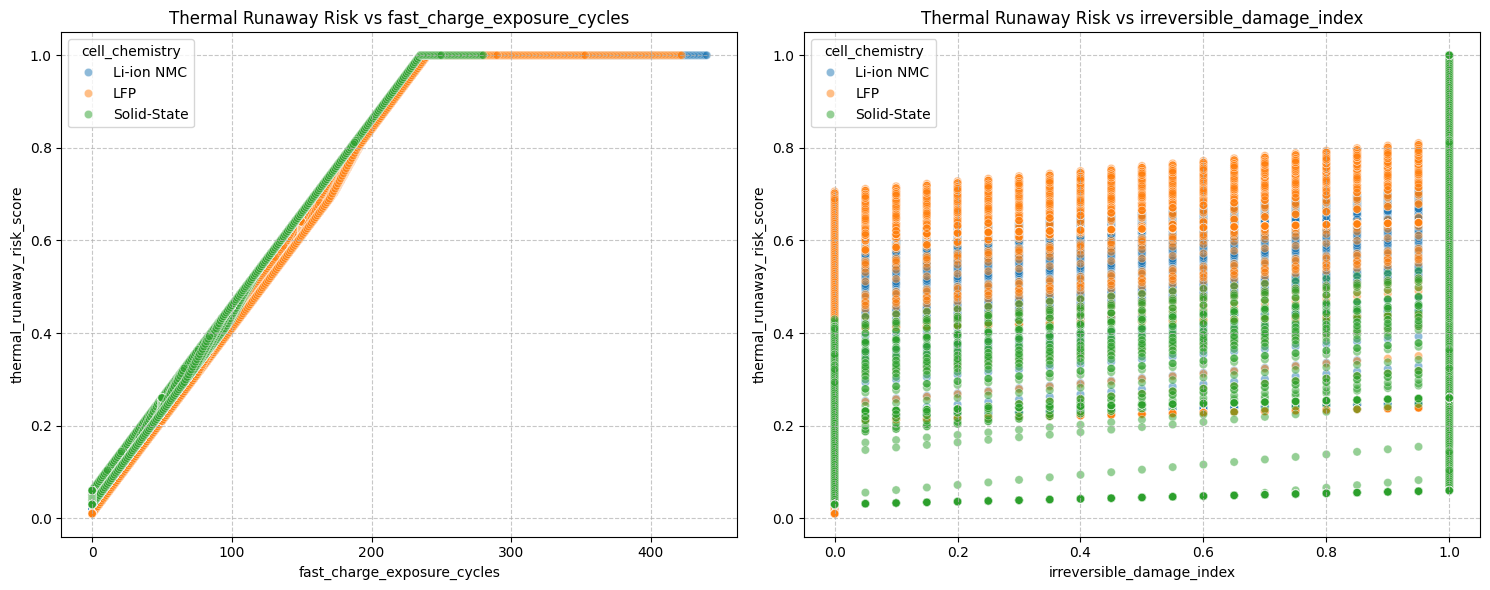

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 데이터 로드 및 전처리
df = pd.read_csv('battery_failure_surfaces.csv')

# 수치형 변수 선택 (상관관계 분석용)
# 배터리 타입(문자열)을 제외하고 계산 가능한 변수들만 리스트로 정의합니다.
numerical_cols = [
    'cell_temperature_C', 'internal_resistance_mOhm', 'charge_rate_C',
    'discharge_rate_C', 'capacity_retention_%', 'cumulative_high_temp_cycles',
    'fast_charge_exposure_cycles', 'irreversible_damage_index',
    'thermal_runaway_risk_score'
]

# 2. 전체 데이터에 대한 상관관계 분석
# corr() 함수를 사용해 모든 변수 간의 상관계수를 계산합니다.
corr_matrix = df[numerical_cols].corr()
# 'thermal_runaway_risk_score'와 관련된 값만 추출하여 내림차순 정렬합니다.
risk_correlation = corr_matrix['thermal_runaway_risk_score'].sort_values(ascending=False)

print("전체 데이터 기준 'thermal_runaway_risk_score'와의 상관계수:")
print(risk_correlation)
print("-" * 30)

# 3. 화학 조성(Cell Chemistry)별 상관관계 분석
# 데이터셋에 존재하는 모든 배터리 화학 조성 종류를 가져옵니다.
chemistries = df['cell_chemistry'].unique()

for chem in chemistries:
    # 해당 화학 조성에 해당하는 데이터만 필터링합니다.
    df_subset = df[df['cell_chemistry'] == chem]
    
    # 필터링된 데이터 내부에서 상관분석을 수행합니다.
    corr_subset = df_subset[numerical_cols].corr()
    risk_corr_subset = corr_subset['thermal_runaway_risk_score'].sort_values(ascending=False)
    
    # 상위 5개 연관 인자를 출력합니다. (0번 인덱스는 자기 자신이므로 6개까지 출력)
    print(f"\n{chem} 기준 'thermal_runaway_risk_score'와의 상관계수 Top 5:")
    print(risk_corr_subset.head(6)) 

# 4. 주요 인자 시각화 (산점도)
# 전체 기준 가장 상관관계가 높은 상위 2개 변수(급속충전횟수 등)를 선정합니다.
top_features = risk_correlation.index[1:3].tolist() 

plt.figure(figsize=(15, 6))

for i, feature in enumerate(top_features):
    plt.subplot(1, 2, i+1)
    # x축: 주요 인자, y축: 열폭주 위험 점수, 색상: 배터리 타입
    sns.scatterplot(data=df, x=feature, y='thermal_runaway_risk_score', hue='cell_chemistry', alpha=0.5)
    plt.title(f'Thermal Runaway Risk vs {feature}')
    plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
# 그래프를 이미지 파일로 저장합니다.
plt.savefig('correlation_scatter_plots.png')
print("\n시각화 파일 'correlation_scatter_plots.png'가 생성되었습니다.")

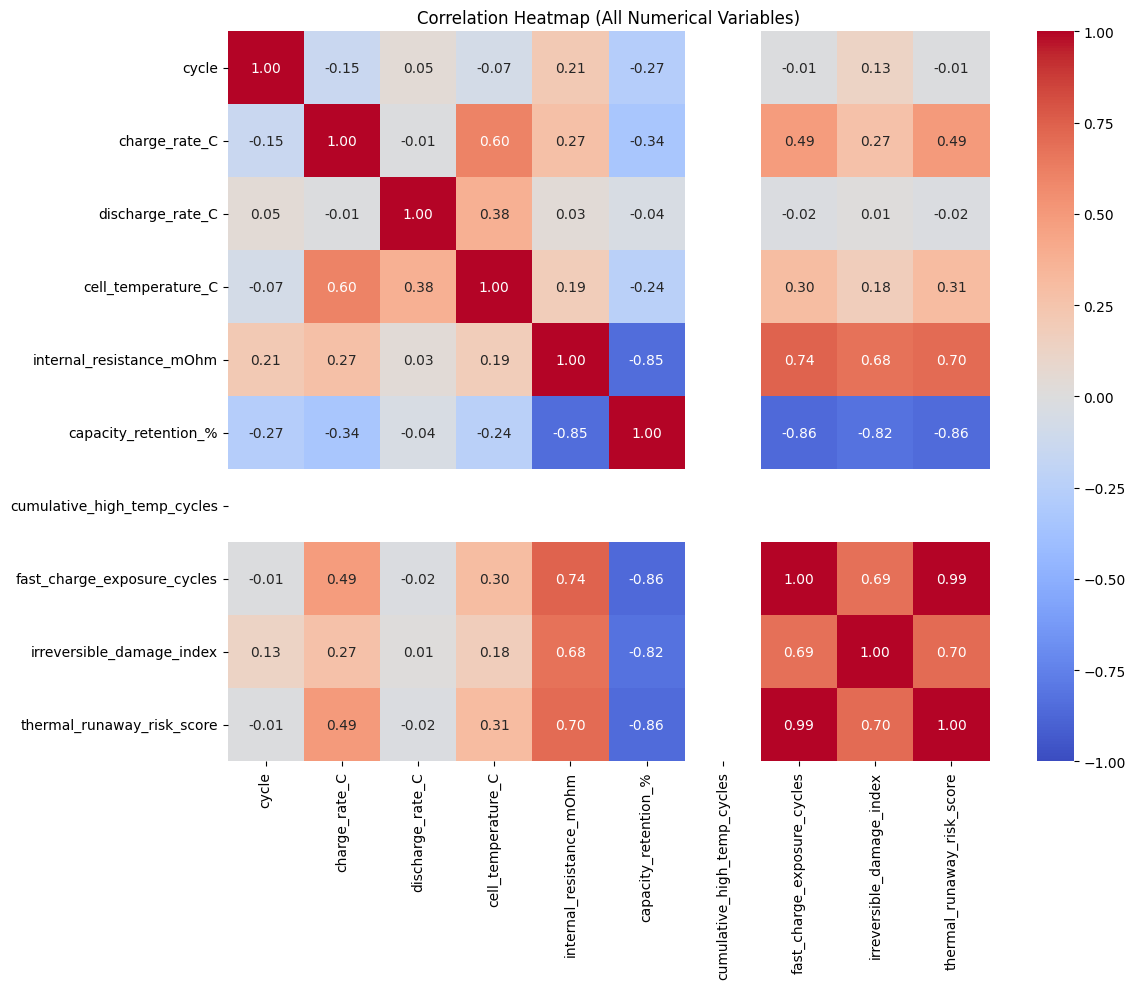

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 데이터 로드
df = pd.read_csv('battery_failure_surfaces.csv')

# 2. 모든 수치형 변수 자동 선택
# select_dtypes 함수를 쓰면 int, float 타입 컬럼을 한 번에 가져올 수 있어 편리합니다.
all_numerical_df = df.select_dtypes(include=['number'])

# 3. 상관계수 계산
corr_all = all_numerical_df.corr()

# 4. 전체 히트맵 시각화
plt.figure(figsize=(12, 10)) # 변수가 많으므로 크기를 키움
sns.heatmap(corr_all, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Heatmap (All Numerical Variables)')
plt.tight_layout()
plt.savefig('all_vars_heatmap.png')

수정된 시각화 파일 'deep_dive_analysis_line.png'가 생성되었습니다.


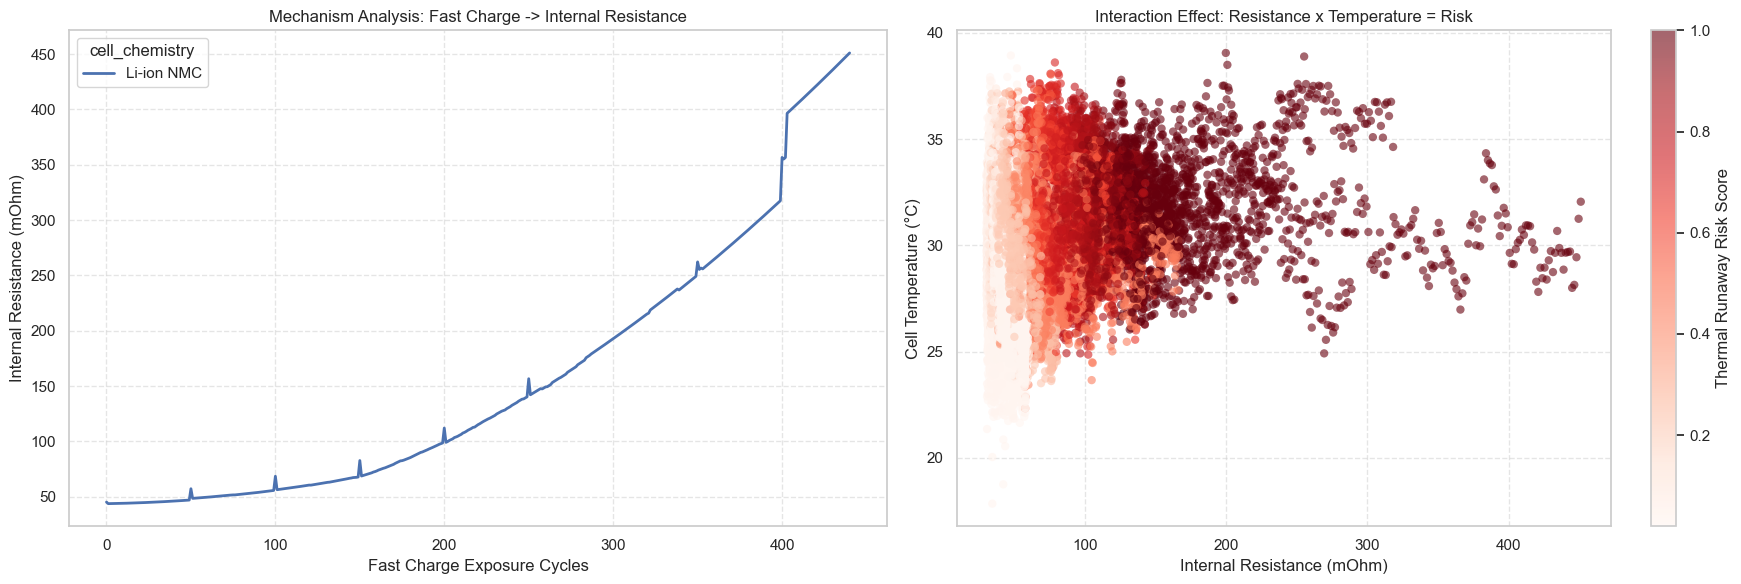

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 데이터 로드
df = pd.read_csv('Li-ion_NMC_data.csv')

# 2. 그래프 설정
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# --- 분석 1: 인과관계 메커니즘 (급속 충전 -> 내부 저항) ---
# 수정: 산점도(scatterplot) 대신 선 그래프(lineplot) 사용
# '직선' 느낌을 주기 위해 errorbar=None으로 설정하여 신뢰구간 제거하고 선만 깔끔하게 표시
sns.lineplot(
    data=df, 
    x='fast_charge_exposure_cycles', 
    y='internal_resistance_mOhm', 
    hue='cell_chemistry', 
    linewidth=2, # 선 두께 조정
    errorbar=None, # 신뢰구간(음영) 제거하여 깔끔한 선으로 표현
    ax=axes[0]
)
axes[0].set_title('Mechanism Analysis: Fast Charge -> Internal Resistance')
axes[0].set_xlabel('Fast Charge Exposure Cycles')
axes[0].set_ylabel('Internal Resistance (mOhm)')
axes[0].grid(True, linestyle='--', alpha=0.5)


# --- 분석 2: 복합 위험 구간 (내부 저항 x 온도 -> 위험도) ---
# 기존 유지: 저항과 온도가 결합될 때 위험도가 어떻게 분포하는지 봅니다.
sc = axes[1].scatter(
    df['internal_resistance_mOhm'], 
    df['cell_temperature_C'], 
    c=df['thermal_runaway_risk_score'], 
    cmap='Reds', 
    alpha=0.6,
    edgecolors='none'
)
axes[1].set_title('Interaction Effect: Resistance x Temperature = Risk')
axes[1].set_xlabel('Internal Resistance (mOhm)')
axes[1].set_ylabel('Cell Temperature (°C)')
plt.colorbar(sc, ax=axes[1], label='Thermal Runaway Risk Score')
axes[1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
print("수정된 시각화 파일 'deep_dive_analysis_line.png'가 생성되었습니다.")

시각화 파일 'nmc_deep_dive_visuals.png'가 생성되었습니다.


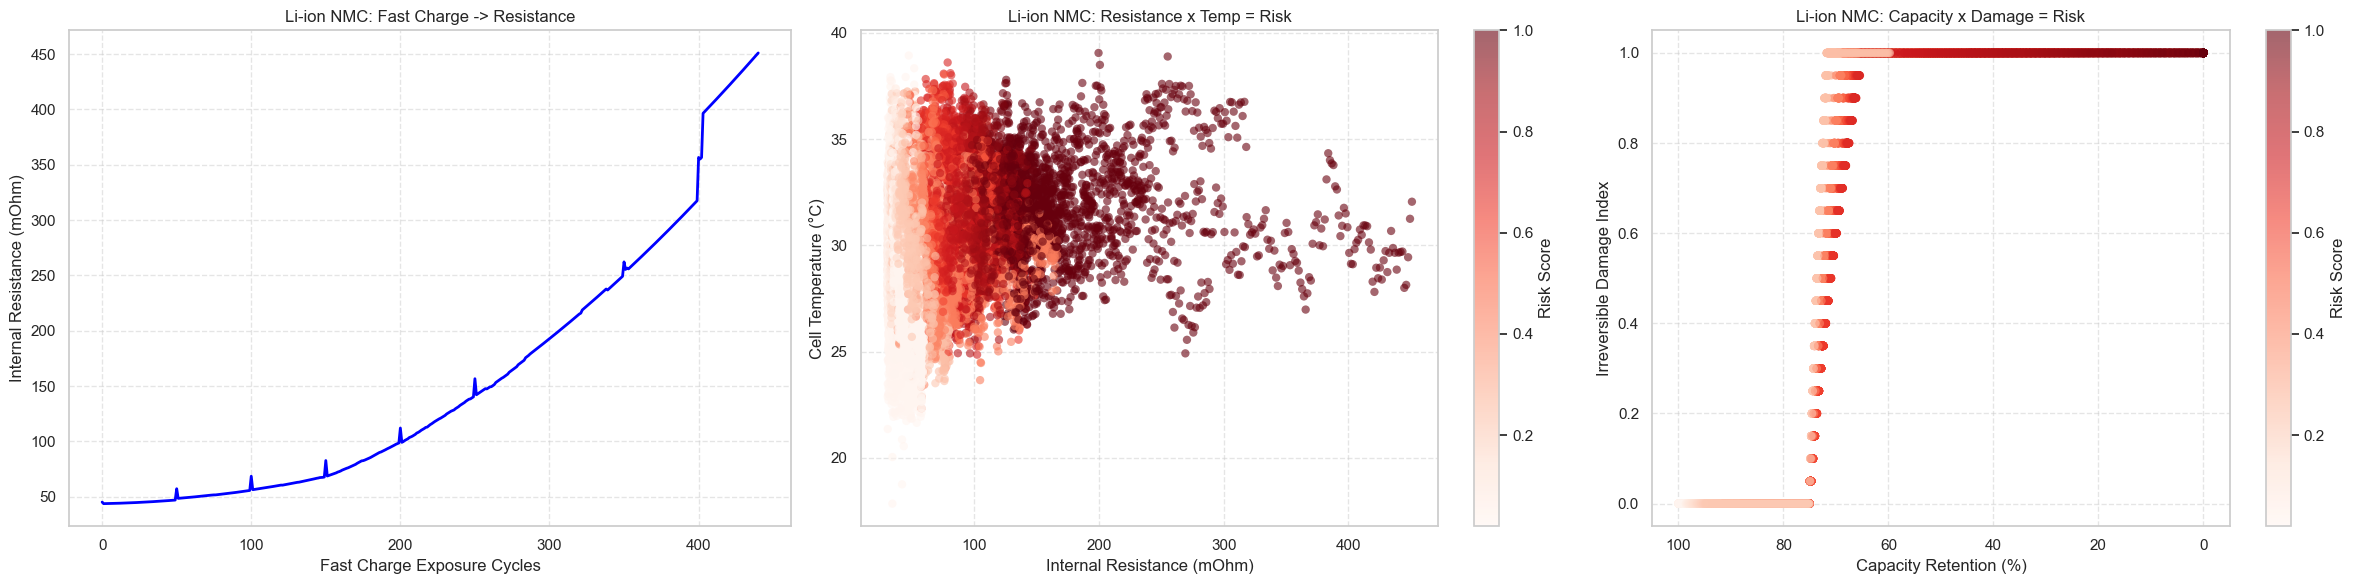

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 데이터 로드
df = pd.read_csv('battery_failure_surfaces.csv')

# Li-ion NMC 데이터만 필터링
df_nmc = df[df['cell_chemistry'] == 'Li-ion NMC']

# 2. 그래프 설정
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# --- 분석 1: 인과관계 메커니즘 (Trend Line) ---
# 급속 충전 -> 내부 저항 (깔끔한 선 그래프)
sns.lineplot(
    data=df_nmc, 
    x='fast_charge_exposure_cycles', 
    y='internal_resistance_mOhm', 
    linewidth=2, 
    errorbar=None,
    color='blue',
    ax=axes[0]
)
axes[0].set_title('Li-ion NMC: Fast Charge -> Resistance')
axes[0].set_xlabel('Fast Charge Exposure Cycles')
axes[0].set_ylabel('Internal Resistance (mOhm)')
axes[0].grid(True, linestyle='--', alpha=0.5)

# --- 분석 2: 복합 위험 구간 (Scatter with Color) ---
# 저항 x 온도 -> 위험도 (색상으로 위험도 표현)
sc1 = axes[1].scatter(
    df_nmc['internal_resistance_mOhm'], 
    df_nmc['cell_temperature_C'], 
    c=df_nmc['thermal_runaway_risk_score'], 
    cmap='Reds', 
    alpha=0.6,
    edgecolors='none'
)
axes[1].set_title('Li-ion NMC: Resistance x Temp = Risk')
axes[1].set_xlabel('Internal Resistance (mOhm)')
axes[1].set_ylabel('Cell Temperature (°C)')
plt.colorbar(sc1, ax=axes[1], label='Risk Score')
axes[1].grid(True, linestyle='--', alpha=0.5)

# --- 분석 3: 노화와 손상 (Scatter with Color) ---
# 용량 x 손상 -> 위험도
sc2 = axes[2].scatter(
    df_nmc['capacity_retention_%'], 
    df_nmc['irreversible_damage_index'], 
    c=df_nmc['thermal_runaway_risk_score'], 
    cmap='Reds', 
    alpha=0.6,
    edgecolors='none'
)
axes[2].set_title('Li-ion NMC: Capacity x Damage = Risk')
axes[2].set_xlabel('Capacity Retention (%)')
axes[2].set_ylabel('Irreversible Damage Index')
axes[2].invert_xaxis() # 용량 감소 방향(오른쪽->왼쪽)
plt.colorbar(sc2, ax=axes[2], label='Risk Score')
axes[2].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
print("시각화 파일 'nmc_deep_dive_visuals.png'가 생성되었습니다.")